# Terrain Classification - Combined User Data
### Created by Keenan McConkey 2019.5.25

In [3]:
from __future__ import absolute_import, division, print_function

import pandas as pd

import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal
from scipy import stats

from datetime import datetime
from decimal import Decimal

import pymrmr
import sklearn

## Part 1 - Importing Preprocessed Data

### Part (0) - Functions for Data Import

In [4]:
# Easier to read column names - Convention is different for older datasets
frame_columns = ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro', 'Epoch Time']
std_columns =   ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro', 'Run Time', 'Epoch Time']
data_columns =  ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro']

# Columns not currently used for classification - Mostly for phone data
unused_columns = ('LINEAR ACCELERATION X (m/s²)', 'LINEAR ACCELERATION Y (m/s²)', 'LINEAR ACCELERATION Z (m/s²)',
                  'GRAVITY X (m/s²)', 'GRAVITY Y (m/s²)', 'GRAVITY Z (m/s²)', 
                  'MAGNETIC FIELD X (μT)', 'MAGNETIC FIELD Y (μT)', 'MAGNETIC FIELD Z (μT)',
                  'ORIENTATION X (pitch °)', 'ORIENTATION Y (roll °)', 'ORIENTATION Z (azimuth °)',
                  'Pitch (Deg)', 'Roll (Deg)', 'Heading (Deg)')

'''Get columns for given label'''
def get_columns(_label):
    columns = []
    
    # New naming scheme
    if 'Phone' in _label or 'Wheel' in _label or 'Module' in _label:
        columns = std_columns.copy()
    # Old frame data naming scheme
    elif 'Frame' in _label:
        columns = frame_columns.copy()
    else:
        raise Exception('Unknown label')
    
    # For transformed datasets replace time columns with frequency
    if 'FFT' in _label or 'PSD' in _label:
        columns.remove('Epoch Time')
        
        if 'Run Time' in columns:
            columns.remove('Run Time')
        
        columns.append('Frequency')
        
    return columns

In [5]:
# Types of terrains, placements, and transforms used
terrains = ['Concrete', 'Carpet', 'Linoleum', 'Asphalt', 'Sidewalk', 'Grass', 'Gravel']
placements = ['Middle']
transforms = ['FFT', 'PSDLog', 'PSD']

'''Get the integer terrain value of a given label'''
def get_terrain_num(_label):
    for i, terrain in enumerate(terrains):
        if terrain in _label:
            return i
        
    raise Exception('Unknown terrain')

'''Get the name associated with a terrain integer'''
def get_terrain_name(terrain_num):
    return terrains[terrain_num]

'''Get the placement location name for given label'''
def get_placement(_label):
    for placement in placements:
        if placement in _label:
            return placement
    
    raise Exception('Unknown placement')

'''Get the transform used for given label'''
def get_transform(_label):
    for transform in transforms:
        if transform in _label:
            return transform
    
    raise Exception('Unkown transform')

### Part (b) - Import Processed Data from 2 Users

In [6]:
'''Combine data from labelled datasets into a single dataframe'''
def combine_datasets(datasets):
    return pd.concat(list(datasets.values()), ignore_index=True)

In [19]:
# Convert features
feat_combined_users = {}
feat_combined_users.update({'Keenan': pd.read_csv('processed_data/upgraded_keenan/Middle_Features_Filt.csv')})
feat_combined_users.update({'Kevin': pd.read_csv('processed_data/upgraded_kevin/Middle_Features_Filt.csv')})

In [20]:
# Convert features
fft_combined_users = {}
fft_combined_users.update({'Keenan': pd.read_csv('processed_data/upgraded_keenan/Middle_FFTs_Filt.csv')})
fft_combined_users.update({'Kevin': pd.read_csv('processed_data/upgraded_kevin/Middle_FFTs_Filt.csv')})

In [21]:
# Convert features
psd_log_combined_users = {}
psd_log_combined_users.update({'Keenan': pd.read_csv('processed_data/upgraded_keenan/Middle_PSDLogs_Filt.csv')})
psd_log_combined_users.update({'Kevin': pd.read_csv('processed_data/upgraded_kevin/Middle_PSDLogs_Filt.csv')})

In [22]:
feat_combined = {}
fft_combined = {}
psd_log_combined = {}
feat_combined.update({'Middle': combine_datasets(feat_combined_users)})
fft_combined.update({'Middle': combine_datasets(fft_combined_users)})
psd_log_combined.update({'Middle': combine_datasets(psd_log_combined_users)})

## Part 7 - Feature Selection mRMR (minimum Redunancy Maximum Relevance)

Try to find which features are most relevant, from all directions.

Features can be transforms or extracted features.

mRMR tries to find which features have the highest correlation to classified state and lowest correlation with other variables.

### Part (a) - Compare From All Datasets

#### Part (i) - Extracted Features

In [118]:
pymrmr.mRMR(data=feat_combined['Middle'], method='MID', nfeats=20)

['Excess Kurtosis X Gyro Middle',
 'Zero Crossing Rate Z Gyro Middle',
 'Excess Kurtosis Y Gyro Middle',
 'Variance Frequency Y Gyro Middle',
 'Excess Kurtosis Y Accel Middle',
 'Mean Square Frequency Z Gyro Middle',
 'Zero Crossing Rate Y Accel Middle',
 'Variance Frequency X Gyro Middle',
 'Excess Kurtosis Z Gyro Middle',
 'Excess Kurtosis Z Accel Middle',
 'Mean Square Frequency Z Accel Middle',
 'Variance Frequency X Accel Middle',
 'Variance Frequency Z Gyro Middle',
 'Mean Y Gyro Middle',
 'Excess Kurtosis X Accel Middle',
 'Variance Frequency Y Accel Middle',
 'Autocorrelation Y Accel Middle',
 'Zero Crossing Rate Z Accel Middle',
 'Skew Y Gyro Middle',
 'Min X Accel Middle']

#### Part (ii) - FFT

In [119]:
pymrmr.mRMR(data=fft_combined['Middle'], method='MID', nfeats=20)

['FFT 29.0 Hz Z Accel Middle',
 'FFT 0.0 Hz Y Accel Middle',
 'FFT 24.0 Hz Z Accel Middle',
 'FFT 28.0 Hz Z Accel Middle',
 'FFT 22.0 Hz Z Accel Middle',
 'FFT 30.0 Hz Z Accel Middle',
 'FFT 26.0 Hz Z Accel Middle',
 'FFT 27.0 Hz Z Accel Middle',
 'FFT 31.0 Hz Z Accel Middle',
 'FFT 25.0 Hz Z Accel Middle',
 'FFT 23.0 Hz Z Accel Middle',
 'FFT 32.0 Hz Z Accel Middle',
 'FFT 21.0 Hz Z Accel Middle',
 'FFT 20.0 Hz Z Accel Middle',
 'FFT 33.0 Hz Z Accel Middle',
 'FFT 19.0 Hz Z Accel Middle',
 'FFT 0.0 Hz Z Gyro Middle',
 'FFT 34.0 Hz Z Accel Middle',
 'FFT 18.0 Hz Z Accel Middle',
 'FFT 17.0 Hz Z Accel Middle']

#### Part (iii) - PSD Log

In [120]:
pymrmr.mRMR(data=psd_log_combined['Middle'], method='MID', nfeats=20)

['PSDLog 31.0 Hz Y Gyro Middle',
 'PSDLog 0.0 Hz Y Gyro Middle',
 'PSDLog 14.0 Hz Y Gyro Middle',
 'PSDLog 37.0 Hz Y Accel Middle',
 'PSDLog 3.0 Hz Y Gyro Middle',
 'PSDLog 30.0 Hz Y Gyro Middle',
 'PSDLog 11.0 Hz Y Gyro Middle',
 'PSDLog 15.0 Hz Y Gyro Middle',
 'PSDLog 1.0 Hz Y Gyro Middle',
 'PSDLog 32.0 Hz Y Gyro Middle',
 'PSDLog 40.0 Hz Y Accel Middle',
 'PSDLog 12.0 Hz Y Gyro Middle',
 'PSDLog 33.0 Hz Y Gyro Middle',
 'PSDLog 2.0 Hz Y Gyro Middle',
 'PSDLog 16.0 Hz Y Gyro Middle',
 'PSDLog 34.0 Hz Y Accel Middle',
 'PSDLog 13.0 Hz Y Gyro Middle',
 'PSDLog 43.0 Hz Y Accel Middle',
 'PSDLog 17.0 Hz Y Gyro Middle',
 'PSDLog 8.0 Hz Y Gyro Middle']

## Part 8 - Training Classifiers

In [26]:
# Names of different feature vectors
from sklearn.metrics import accuracy_score
vector_names = ('ExtractedFeatures', 'FFT', 'PSDLog')

In [27]:
'''Compare actual vs predicted label for each data window'''
def plot_classifier_accuracy(test, predict, classifer_name):
    plt.clf()
    plt.figure(figsize=(16, 10))
    
    plt.plot(test, marker='*', label='Actual Label')
    plt.plot(predict, marker='o', label='Predicted Label')
    
    plt.title('Classification Accuracy of ' + classifer_name + ' for Each Window')
    plt.xlabel('Data Window (Across All Datasets)')
    plt.ylabel('Terrain Label')
    
    # Y ticks are terrain types
    plt.yticks(np.arange(0, len(terrains)), terrains)
    
    plt.legend()
    plt.show()

In [28]:
from sklearn.metrics import confusion_matrix

'''Plot confusion matrix of test data'''
def plot_confusion_matrix(test, predict, classes, normalize=False, title=None, save_fig=False):
    plt.clf()
    if not title:
        if normalize:
            title = "Normalized confusion matrix"
        else:
            title = "Confusion matrix"
    
    # Compute confusion matrix
    cm = confusion_matrix(test, predict)
    
    # Normalization condition
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Draw color map of confusion matrix
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    # Show all ticks and label them
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title, ylabel='Actual label', xlabel='Predicted label')
    
    # Rotate tick labels and align
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
    
    # Add text annotation
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha='center', va='center',
                    color='white' if cm[i, j] > thresh else 'black')
    
    fig.tight_layout()
    
    # Save figure to file
    if save_fig:
        save_name = '/home/caris/Wheelchair-Terrain-Classification/imgs/cm/' + title + '.png'
        plt.savefig(save_name)
    else:
        plt.show()

In [29]:
'''Return train and dataset from input placement dictionary of combined datasets'''
def extract_train_test(placements_combined, train_frac=0.8):
    # Dictionary for each placement in (Left, Middle, Right)
    train_combined = {}
    test_combined = {}
    train_labels = {}
    test_labels = {}
    
    for placement, combined in placements_combined.items():
        train_combined.update({placement: combined.sample(frac=train_frac, random_state=0)})
        test_combined.update({placement: combined.drop(train_combined[placement].index)})
        
        train_labels.update({placement: train_combined[placement].pop('Label')})
        test_labels.update({placement: test_combined[placement].pop('Label')})
    
    # Return tuble of train and test: (Combined Data, Labels)
    return (train_combined, train_labels), (test_combined, test_labels)

In [30]:
from sklearn.externals import joblib

'''Train model and predict test data for each placement'''
def predict_each_placement(train, test, model, model_save_name=None):
    # Placement dictionary of predicted labels
    predict_labels = {}
    (train_data, train_labels) = train
    (test_data, test_labels) = test
    
    # Each of Middle, Left, Right
    for placement in placements:
        # Power dataset only contains Middle placement
        if placement in train_data.keys():
            model.fit(train_data[placement], train_labels[placement])
            predict_labels.update({placement: model.predict(test_data[placement])})
            
            # Save model for placement to Pickle file
            if model_save_name:
                joblib.dump(model, 'models/' + placement + '_' + model_save_name + '.pkl')
            
    return predict_labels

/home/caris/anaconda2/envs/keenanm/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.


In [31]:
from sklearn.model_selection import KFold

'''Run train test k-fold times
   Returns predicted labels for each K Fold Test'''

def train_test_k_fold(placements_combined, n_splits, model):
    # Placement dictionary, each element a list of (Predicted, Actual) labels for each k fold
    placement_predicted_actual = {}
    
    kf = KFold(n_splits=n_splits, shuffle=True)
    
    for placement, combined in placements_combined.items():
        # Copy data
        data = combined.copy()
        
        # Extract terrain labels
        labels = data.pop('Label')
        
        # Array of predicted labels for each k fold
        predict_k_fold = []
        test_k_fold = []
        
        # Split into n splits
        for train_index, test_index in kf.split(data):
            train, test = data.loc[train_index], data.loc[test_index]
            train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
            
            # Train and test model
            model.fit(train, train_labels)
            predict_k_fold.append(model.predict(test))
            test_k_fold.append(test_labels)
            
        placement_predicted_actual.update({placement: (predict_k_fold, test_k_fold)})
    
    return placement_predicted_actual

In [32]:
def save_all_cm(_test_vectors, _predict_vectors, classifier_name, save_tag=None):
    for i, vector_name in enumerate(vector_names):
        for placement in placements:
            save_title = 'CM_' + classifier_name + '_' + placement + '_' + vector_name
            if save_tag:
                save_title += '_' + save_tag 
            
            # Sometimes only Middle placement
            if placement in _test_vectors[i][1].keys():
                plot_confusion_matrix(test_vectors[i][1][placement], predict_vectors[i][placement],
                                      classes=terrains, normalize=True,
                                      title=save_title, save_fig=True)

In [33]:
# Dataframe table of accuracies for each classifier for each placement
vector_indices = [placement + ' ' + vector for placement in placements for vector in vector_names]
accuracy_table = pd.DataFrame({'Vector': vector_indices})

#### N.B. Using the entire dataset

In [34]:
# Extract train and test from each set of features
train_feat, test_feat = extract_train_test(feat_combined)
train_fft, test_fft = extract_train_test(fft_combined)
train_psd_log, test_psd_log = extract_train_test(psd_log_combined)

In [35]:
print('Total number of Middle train data windows: {} '.format(len(train_feat[0]['Middle'])))

Total number of Middle train data windows: 3117 


In [36]:
print('Total number of Middle test data windows: {} '.format(len(test_feat[0]['Middle'])))

Total number of Middle test data windows: 779 


### Part (a) - Naive Bayes

In [37]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()

In [38]:
predict_feat = predict_each_placement(train_feat, test_feat, model)
predict_fft = predict_each_placement(train_fft, test_fft, model)
predict_psd_log = predict_each_placement(train_psd_log, test_psd_log, model)

In [39]:
# Try saving a model
predict_each_placement(train_feat, test_feat, model, model_save_name='NB_Features')

{'Middle': array([4, 3, 4, 3, 4, 4, 0, 5, 4, 3, 2, 4, 5, 4, 0, 6, 4, 4, 4, 4, 1, 4,
        4, 4, 4, 4, 4, 0, 4, 0, 4, 0, 4, 1, 0, 4, 3, 4, 4, 4, 6, 0, 4, 4,
        4, 4, 4, 1, 1, 4, 0, 0, 4, 4, 5, 0, 4, 0, 4, 4, 3, 3, 4, 1, 4, 4,
        4, 4, 4, 4, 6, 0, 0, 0, 3, 0, 4, 0, 1, 4, 4, 4, 4, 3, 4, 4, 3, 3,
        3, 3, 3, 2, 6, 0, 1, 3, 4, 4, 3, 4, 4, 0, 3, 3, 0, 3, 4, 3, 4, 4,
        4, 4, 4, 0, 4, 4, 0, 0, 4, 0, 0, 4, 6, 4, 0, 0, 1, 4, 1, 0, 1, 2,
        0, 0, 4, 0, 0, 2, 4, 4, 5, 4, 5, 4, 4, 0, 5, 1, 4, 0, 0, 3, 0, 3,
        2, 4, 4, 4, 4, 5, 4, 4, 4, 5, 5, 3, 4, 4, 0, 3, 4, 4, 4, 6, 2, 4,
        0, 0, 4, 6, 4, 1, 3, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 2, 2, 3, 0, 4,
        4, 4, 4, 6, 4, 4, 4, 3, 0, 0, 0, 3, 6, 5, 4, 5, 3, 4, 3, 0, 1, 4,
        3, 0, 1, 4, 4, 4, 0, 0, 4, 0, 0, 1, 4, 0, 0, 4, 4, 0, 0, 4, 3, 1,
        1, 4, 4, 1, 5, 4, 4, 4, 0, 4, 4, 1, 1, 3, 4, 4, 4, 3, 4, 3, 0, 4,
        0, 3, 5, 4, 3, 3, 4, 4, 4, 3, 4, 0, 3, 0, 3, 5, 3, 3, 5, 4, 4, 4,
        1, 3, 4, 4, 4, 4, 4,

In [40]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_psd_log[1]['Middle'], predict_psd_log['Middle'])
print('Right PSD Gaussian Naive Bayes Classifer: Accuracy = {}'.format(accuracy))

Right PSD Gaussian Naive Bayes Classifer: Accuracy = 0.540436456996149


In [41]:
# Compute accuracy of a k-fold test/train
predict, actual = train_test_k_fold(psd_log_combined, 3, model)['Middle']

print ('Right PSD Gaussian Naive Bayes Classifer 5-fold Accuracy: ')

for i in range(len(predict)):
    print(accuracy_score(actual[i], predict[i]))

Right PSD Gaussian Naive Bayes Classifer 5-fold Accuracy: 
0.5319476520400308
0.5311778290993071
0.5731895223420647


<Figure size 432x288 with 0 Axes>

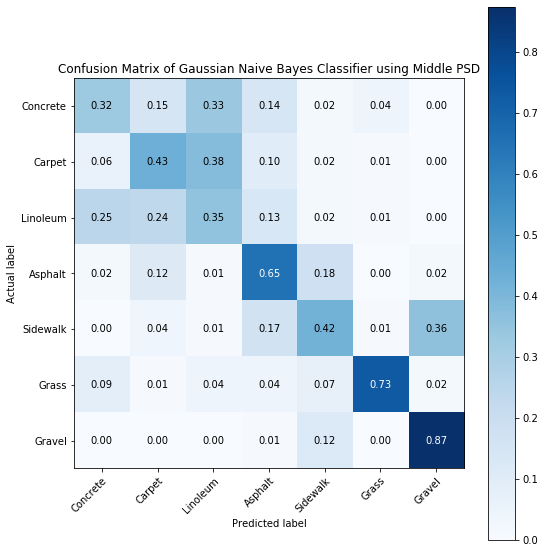

In [42]:
plot_confusion_matrix(test_psd_log[1]['Middle'], predict_psd_log['Middle'], classes=terrains, normalize=True, 
                      title='Confusion Matrix of Gaussian Naive Bayes Classifier using Middle PSD')

In [43]:
# Try saving all CM images
#save_all_cm(test_vectors, predict_vectors, 'NB')

### Part (b) - k Nearest Neighbour

In [44]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=3)

In [45]:
predict_feat = predict_each_placement(train_feat, test_feat, model)
predict_fft = predict_each_placement(train_fft, test_fft, model)
predict_psd_log = predict_each_placement(train_psd_log, test_psd_log, model)

In [46]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_psd_log[1]['Middle'], predict_psd_log['Middle'])
print('Middle PSD k Nearest Neighbor Classifer: Accuracy = {}'.format(accuracy))

Middle PSD k Nearest Neighbor Classifer: Accuracy = 0.6071887034659821


<Figure size 432x288 with 0 Axes>

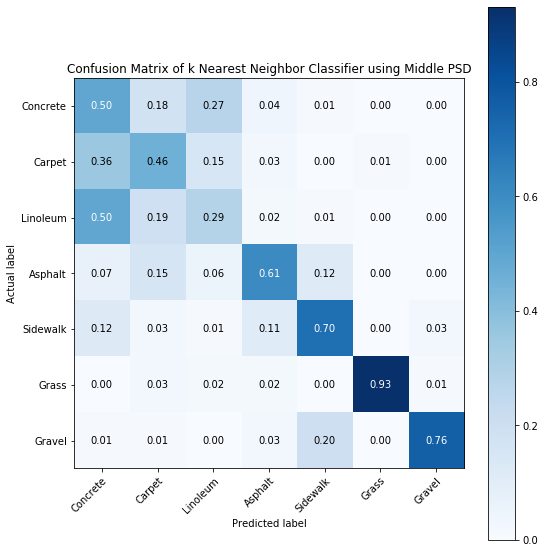

In [47]:
plot_confusion_matrix(test_psd_log[1]['Middle'], predict_psd_log['Middle'], classes=terrains, normalize=True, 
                      title='Confusion Matrix of k Nearest Neighbor Classifier using Middle PSD')

### Part (c) - Decision Trees

In [48]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()

In [49]:
predict_feat = predict_each_placement(train_feat, test_feat, model)
predict_fft = predict_each_placement(train_fft, test_fft, model)
predict_psd_log = predict_each_placement(train_psd_log, test_psd_log, model)

In [50]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_feat[1]['Middle'], predict_feat['Middle'])
print('Middle PSD Decision Tree Classifer: Accuracy = {}'.format(accuracy))

Middle PSD Decision Tree Classifer: Accuracy = 0.7881899871630296


<Figure size 432x288 with 0 Axes>

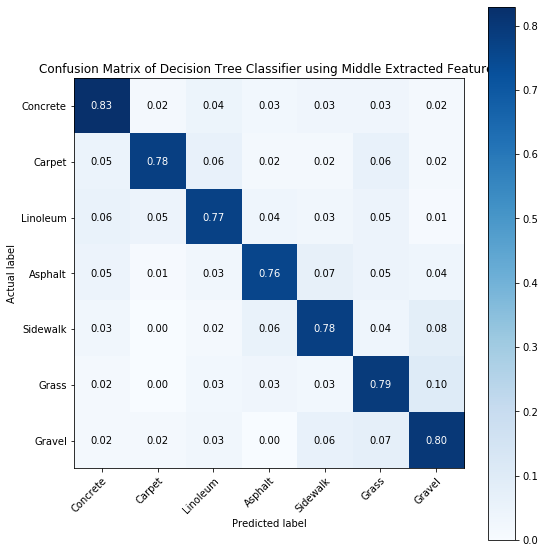

In [51]:
plot_confusion_matrix(test_feat[1]['Middle'], predict_feat['Middle'], classes=terrains, normalize=True, 
                      title='Confusion Matrix of Decision Tree Classifier using Middle Extracted Features')

### Part (d) - Random Forest 

In [52]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100)

In [53]:
predict_feat = predict_each_placement(train_feat, test_feat, model)
predict_fft = predict_each_placement(train_fft, test_fft, model)
predict_psd_log = predict_each_placement(train_psd_log, test_psd_log, model)

In [54]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_psd_log[1]['Middle'], predict_psd_log['Middle'])
print('Middle PSD Log Random Forest Classifer: Accuracy = {}'.format(accuracy))

Middle PSD Log Random Forest Classifer: Accuracy = 0.6726572528883183


<Figure size 432x288 with 0 Axes>

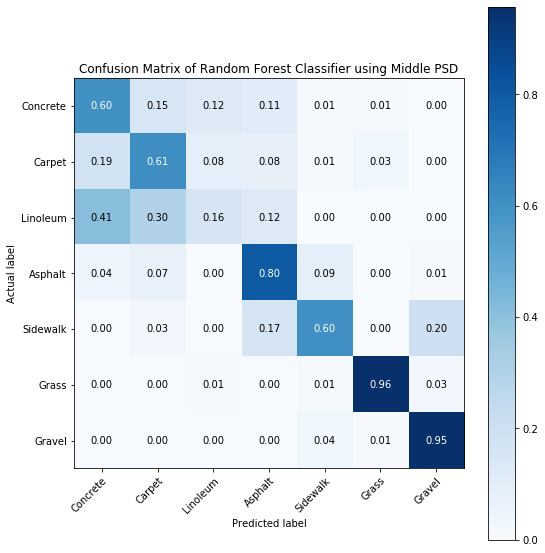

In [55]:
plot_confusion_matrix(test_psd_log[1]['Middle'], predict_psd_log['Middle'], classes=terrains, normalize=True, 
                      title='Confusion Matrix of Random Forest Classifier using Middle PSD')

### Part (e) - AdaBoost

In [56]:
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier()

In [57]:
predict_feat = predict_each_placement(train_feat, test_feat, model)
predict_fft = predict_each_placement(train_fft, test_fft, model)
predict_psd_log = predict_each_placement(train_psd_log, test_psd_log, model)

In [58]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_psd_log[1]['Middle'], predict_psd_log['Middle'])
print('Middle PSD Log AdaBoost Classifer: Accuracy = {}'.format(accuracy))

Middle PSD Log AdaBoost Classifer: Accuracy = 0.4441591784338896


<Figure size 432x288 with 0 Axes>

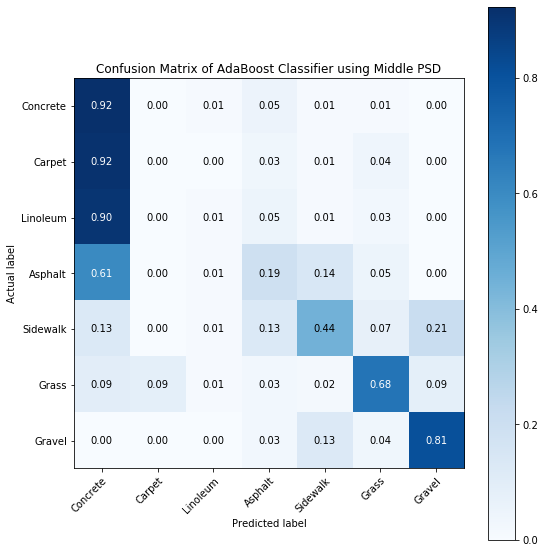

In [59]:
plot_confusion_matrix(test_psd_log[1]['Middle'], predict_psd_log['Middle'], classes=terrains, normalize=True, 
                      title='Confusion Matrix of AdaBoost Classifier using Middle PSD')

### Part (f) - SVM (Support Vector Machine)

In [60]:
from sklearn.svm import SVC
model = SVC(gamma='scale')

In [61]:
# Predict for each of our feature vectors
predict_feat = predict_each_placement(train_feat, test_feat, model)
predict_fft = predict_each_placement(train_fft, test_fft, model)
predict_psd_log = predict_each_placement(train_psd_log, test_psd_log, model)

In [62]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_psd_log[1]['Middle'], predict_psd_log['Middle'])
print('Middle PSD SVM Classifer: Accuracy = {}'.format(accuracy))

Middle PSD SVM Classifer: Accuracy = 0.7381258023106547


<Figure size 432x288 with 0 Axes>

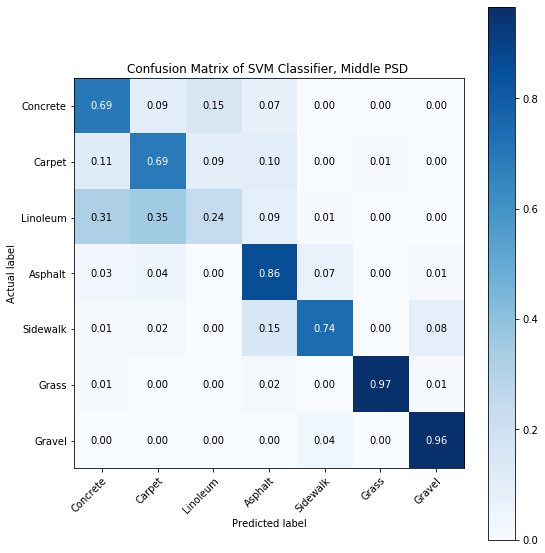

In [63]:
plot_confusion_matrix(test_psd_log[1]['Middle'], predict_psd_log['Middle'], classes=terrains, normalize=True, 
                      title='Confusion Matrix of SVM Classifier, Middle PSD ')

### Part (g) - Create Accuracy Table

In [64]:
# Dictionary of classifiers
classifiers = {'Naive Bayes': GaussianNB(),
               'k Nearest': KNeighborsClassifier(),
               'Decision Tree': DecisionTreeClassifier(), 
               'Random Forest': RandomForestClassifier(n_estimators=100),
               'AdaBoost': AdaBoostClassifier(),
               'Support Vector Machine': SVC(gamma='scale')}

In [65]:
def create_accuracy_table(n_splits):
    # Dataframe table of accuracies for each classifier for each placement
    vector_indices = [vector + ' ' + placement for placement in placements for vector in vector_names]
    accuracy_table = pd.DataFrame({'Vector': vector_indices})

    # Calculate accuracy for each placement for each feature vector and classifier
    for classifier_name, classifier in classifiers.items():
        model = classifier

        # Row dictionary for given model
        rows = {}

        # Get k fold predict and actual labels for each vector
        feat  = train_test_k_fold(feat_combined, n_splits, model)
        fft = train_test_k_fold(fft_combined, n_splits, model)
        psd_log = train_test_k_fold(psd_log_combined, n_splits, model)
        vectors = (feat, fft, psd_log)

        # Add current axis and classifier to row dictionary
        for placement in placements:
            for i, vector_name in enumerate(vector_names):

                index_name = vector_name + ' ' + placement

                # Extract predicted and actual labels
                predict, actual = vectors[i][placement]

                # Take mean accuracy of k fold testing
                accuracies = []
                for j in range(len(predict)):
                    accuracies.append(accuracy_score(actual[j], predict[j]))
                rows.update({index_name: np.mean(accuracies)})

        # Update accuracy table with classifier column by mapping row names to indices
        accuracy_table[classifier_name] = accuracy_table['Vector'].map(rows)
    return accuracy_table

In [66]:
# Create accuracy table for 5 splits, Middle only
accuracy_table = create_accuracy_table(5)
accuracy_table

,Vector,Naive Bayes,k Nearest,Decision Tree,Random Forest,AdaBoost,Support Vector Machine
0,ExtractedFeatures Middle,0.098819,0.379114,0.810580,0.712270,0.483321,0.514115
1,FFT Middle,0.561853,0.578277,0.525663,0.696610,0.452257,0.679929
2,PSDLog Middle,0.544401,0.637066,0.517201,0.673251,0.449185,0.726645


In [67]:
# Create accuracy table for 10 splits, Middle only
accuracy_table = create_accuracy_table(10)
accuracy_table

,Vector,Naive Bayes,k Nearest,Decision Tree,Random Forest,AdaBoost,Support Vector Machine
0,ExtractedFeatures Middle,0.087019,0.388599,0.815702,0.734339,0.474577,0.530532
1,FFT Middle,0.558522,0.580077,0.541080,0.688404,0.443294,0.685333
2,PSDLog Middle,0.546710,0.646811,0.524131,0.680687,0.453300,0.729696


## Part 10 - Combining Feature Selection with Classifiers

In [68]:
def extract_top_features(combined_dataset, nfeats):
    combined_top_features = {}
    
    # Use mRMR to extract features from each placement
    for placement in placements:
        if placement in combined_dataset.keys():
            top_feats = pymrmr.mRMR(data=combined_dataset[placement], method='MID', nfeats=nfeats)
            # Always add label
            top_feats.append('Label')
            
        combined_top_features.update({placement: top_feats})
    
    return combined_top_features

In [69]:
def top_features_only(combined, top_features):
    combined_top = {}
    
    for placement in placements:
        combined_top.update({placement: combined[placement].loc[:, top_features[placement]]})
        
    return combined_top

### Part (a) - Feature Selection on Individual Feature Vectors

#### Part (i) - Extracted Features

In [70]:
model = DecisionTreeClassifier()

In [71]:
feat_top_features = extract_top_features(feat_combined, 10)

In [72]:
feat_combined_top = top_features_only(feat_combined, feat_top_features)
train_feat_top, test_feat_top = extract_train_test(feat_combined_top)
predict_feat_top = predict_each_placement(train_feat_top, test_feat_top, model)

In [73]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_feat_top[1]['Middle'], predict_feat_top['Middle'])
print('DT Classifer with Top 10 Middle Extracted Features: Accuracy = {}'.format(accuracy))

DT Classifer with Top 10 Middle Extracted Features: Accuracy = 0.8677792041078306


<Figure size 432x288 with 0 Axes>

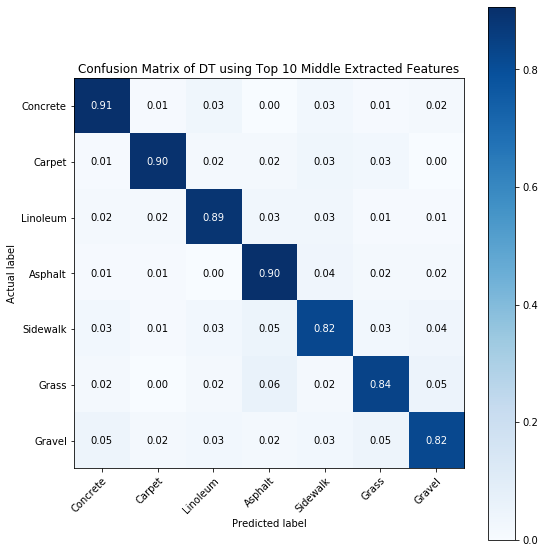

In [74]:
plot_confusion_matrix(test_feat_top[1]['Middle'], predict_feat_top['Middle'], 
                      classes=terrains, normalize=True, 
                      title='Confusion Matrix of DT using Top 10 Middle Extracted Features')

#### Part (ii) - FFT

In [75]:
model = SVC(gamma='scale')

In [76]:
fft_top_features = extract_top_features(fft_combined, 20)

In [77]:
fft_combined_top = top_features_only(fft_combined, fft_top_features)
train_fft_top, test_fft_top = extract_train_test(fft_combined_top)
predict_fft_top = predict_each_placement(train_fft_top, test_fft_top, model)

In [78]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_fft_top[1]['Middle'], predict_fft_top['Middle'])
print('Middle SVM Classifer with Top 20 FFT Features: Accuracy = {}'.format(accuracy))

Middle SVM Classifer with Top 20 FFT Features: Accuracy = 0.5288831835686778


<Figure size 432x288 with 0 Axes>

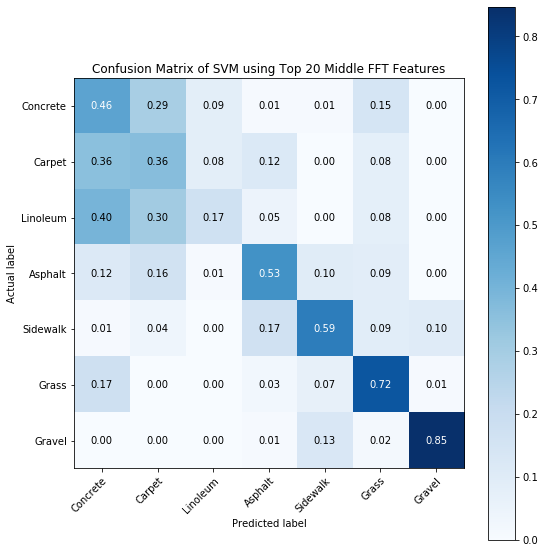

In [79]:
plot_confusion_matrix(test_fft_top[1]['Middle'], predict_fft_top['Middle'], 
                      classes=terrains, normalize=True, 
                      title='Confusion Matrix of SVM using Top 20 Middle FFT Features')

#### Part (iii) - PSD Log

In [80]:
psd_log_top_features = extract_top_features(psd_log_combined, 20)

In [81]:
psd_log_combined_top = top_features_only(psd_log_combined, psd_log_top_features)
train_psd_log_top, test_psd_log_top = extract_train_test(psd_log_combined_top)
predict_psd_log_top = predict_each_placement(train_psd_log_top, test_psd_log_top, model)

In [82]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_psd_log_top[1]['Middle'], predict_psd_log_top['Middle'])
print('Middle SVM Classifer with Top 20 PSD Features: Accuracy = {}'.format(accuracy))

Middle SVM Classifer with Top 20 PSD Features: Accuracy = 0.6341463414634146


<Figure size 432x288 with 0 Axes>

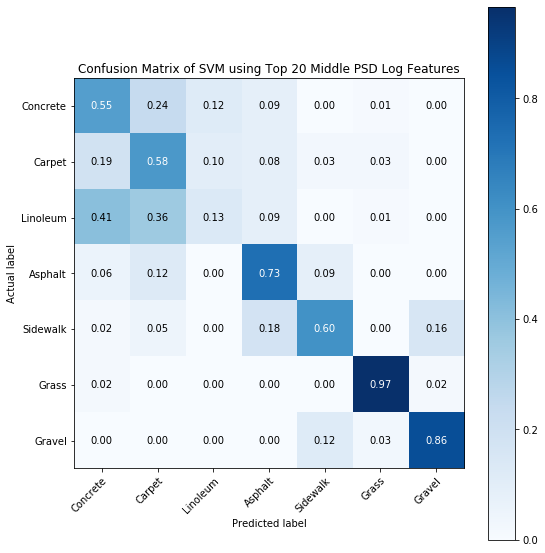

In [117]:
plot_confusion_matrix(test_psd_log_top[1]['Middle'], predict_psd_log_top['Middle'], 
                      classes=terrains, normalize=True, 
                      title='Confusion Matrix of SVM using Top 20 Middle PSD Log Features')

### Part (b) Compute mRMR up to Max Number of Features

In [84]:
feat_top_features = extract_top_features(feat_combined, 90)

In [85]:
feat_top_df = pd.DataFrame(feat_top_features, columns=['Left', 'Middle', 'Right'])
feat_top_df.head()

,Left,Middle,Right
0,NaN,Excess Kurtosis X Gyro Middle,NaN
1,NaN,Zero Crossing Rate Z Gyro Middle,NaN
2,NaN,Excess Kurtosis Y Gyro Middle,NaN
3,NaN,Variance Frequency Y Gyro Middle,NaN
4,NaN,Excess Kurtosis Y Accel Middle,NaN


In [86]:
# Save to .csv for easy access
feat_top_df.to_csv('processed_data/Top_Features_Filt.csv')

In [87]:
fft_top_features = extract_top_features(fft_combined, 240)

In [88]:
fft_top_df = pd.DataFrame(fft_top_features, columns=['Left', 'Middle', 'Right'])
fft_top_df.head()

,Left,Middle,Right
0,NaN,FFT 29.0 Hz Z Accel Middle,NaN
1,NaN,FFT 0.0 Hz Y Accel Middle,NaN
2,NaN,FFT 24.0 Hz Z Accel Middle,NaN
3,NaN,FFT 28.0 Hz Z Accel Middle,NaN
4,NaN,FFT 22.0 Hz Z Accel Middle,NaN


In [89]:
fft_top_df.to_csv('processed_data/Top_FFTs_Filt.csv')

In [90]:
psd_log_top_features = extract_top_features(psd_log_combined, 240)

In [91]:
psd_log_top_df = pd.DataFrame(psd_log_top_features, columns=['Left', 'Middle', 'Right'])
psd_log_top_df.head()

,Left,Middle,Right
0,NaN,PSDLog 31.0 Hz Y Gyro Middle,NaN
1,NaN,PSDLog 0.0 Hz Y Gyro Middle,NaN
2,NaN,PSDLog 14.0 Hz Y Gyro Middle,NaN
3,NaN,PSDLog 37.0 Hz Y Accel Middle,NaN
4,NaN,PSDLog 3.0 Hz Y Gyro Middle,NaN


In [92]:
psd_log_top_df.to_csv('processed_data/Top_PSDs_Filt.csv')

### Part (c) - Compare Top Features to Classification Accuracy

In [93]:
def subset_top(top_features, n_top):
    subset_top_features = {}
    
    for placement, features in top_features.items():
        n_features = features[0:n_top - 1]
        # Add label to ensure it remains with the data
        if 'Label' not in n_features:
            n_features.append('Label')
        
        subset_top_features.update({placement: n_features})
        
    return subset_top_features

In [94]:
def train_n_feats(combined, top_features):
    n_feats_arr = np.arange(5, len(top_features['Middle']), 5)
    accuracies = {'Middle': []}

    # Train and test for each number of top features
    for n_feat in n_feats_arr:
        
        combined_top = top_features_only(combined, subset_top(top_features, n_feat))
        # Get k fold predict and actual labels for each vector
        feature = train_test_k_fold(combined_top, 5, model)
        
        # Compare accuracies vs top features
        for placement in test_feat_top[1].keys():
            # Extract predict and actual
            predict, actual = feature[placement]
            
            # Take mean accuracy of k fold testing
            accuracy_k_fold = []
            
            for i in range(len(predict)):
                accuracy_k_fold.append(accuracy_score(actual[i], predict[i]))
            
            accuracies[placement].append(np.mean(accuracy_k_fold))

    return n_feats_arr, accuracies

#### Part (i) - Compare Feature Vectors of each Placement for Same Classifier

In [95]:
model = DecisionTreeClassifier()

In [96]:
feat_n_features, feat_accuracies = train_n_feats(feat_combined, feat_top_features)

In [97]:
fft_n_features, fft_accuracies = train_n_feats(fft_combined, fft_top_features)

In [98]:
psd_log_n_features, psd_log_accuracies = train_n_feats(psd_log_combined, psd_log_top_features)

In [99]:
def plot_n_features_accuracy(n_features, accuracies, feat_name=None, classifier_name=None):
    plt.clf()
    plt.figure(figsize=(8, 6))
    
    for placement, accuracy in accuracies.items():
        plt.plot(n_features, accuracy, label=placement)
        
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Top Features Used')
    plt.title('Accuracy vs Top ' + feat_name + ', Classifier = ' + classifier_name)
    plt.legend()
    plt.show()

<Figure size 432x288 with 0 Axes>

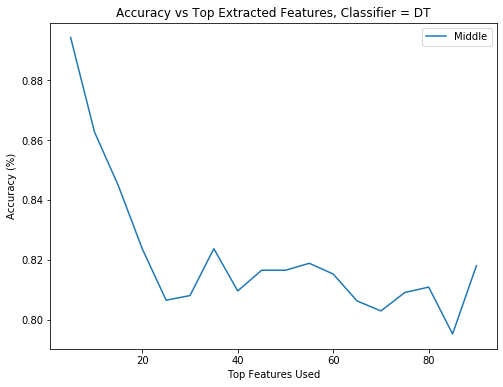

In [100]:
plot_n_features_accuracy(feat_n_features, feat_accuracies, 'Extracted Features', 'DT')

#### Part (ii) - Compare Classifiers for Same Placement and Feature Vector

In [101]:
# Dictionary of accuracy vs number of features for each classifier
classifiers_n_features = {}

In [102]:
for classifier_name, classifier in classifiers.items():
    feat = train_n_feats(feat_combined, feat_top_features)
    fft = train_n_feats(fft_combined, fft_top_features)
    psd_log = train_n_feats(psd_log_combined, psd_log_top_features)
    
    classifiers_n_features.update({classifier_name: (feat, fft, psd_log)})

In [103]:
def plot_classifiers_vs_n_features(vector_num, placement):
    plt.clf()
    plt.figure(figsize=(10, 8))
    
    for class_name, class_vectors  in classifiers_n_features.items():
        (n_features, accuracy) = class_vectors[vector_num]
        
        # If we want to plot all the placements
        if placement == 'All':
            for _placement in placements:
                if _placement in accuracy.keys():
                    plt.plot(n_features, accuracy[_placement], label=class_name + ' ' + _placement)
        else:
            plt.plot(n_features, accuracy[placement], label=class_name)
            
    
    plt.xlabel('Top Features Used')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy vs Top Features for ' + placement + ' ' + vector_names[vector_num])
    plt.legend()
    plt.show()

<Figure size 432x288 with 0 Axes>

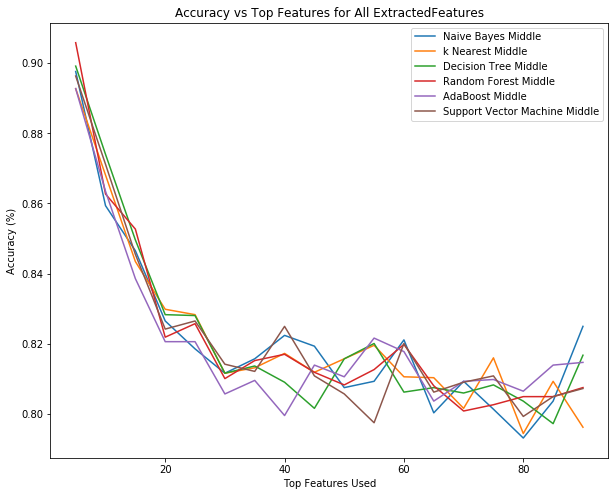

In [104]:
plot_classifiers_vs_n_features(0, 'All')

<Figure size 432x288 with 0 Axes>

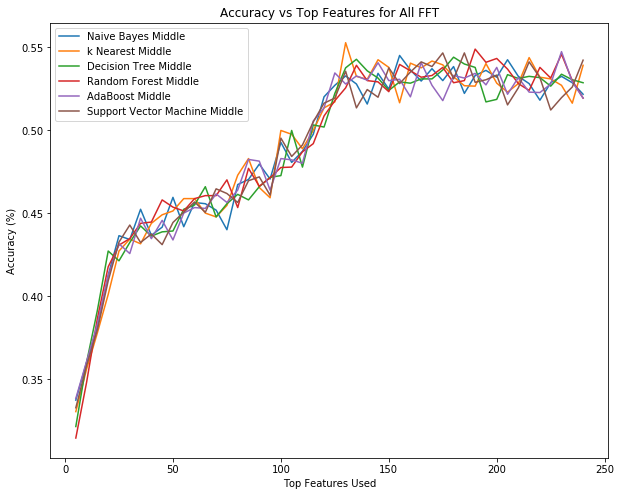

In [105]:
plot_classifiers_vs_n_features(1, 'All')

<Figure size 432x288 with 0 Axes>

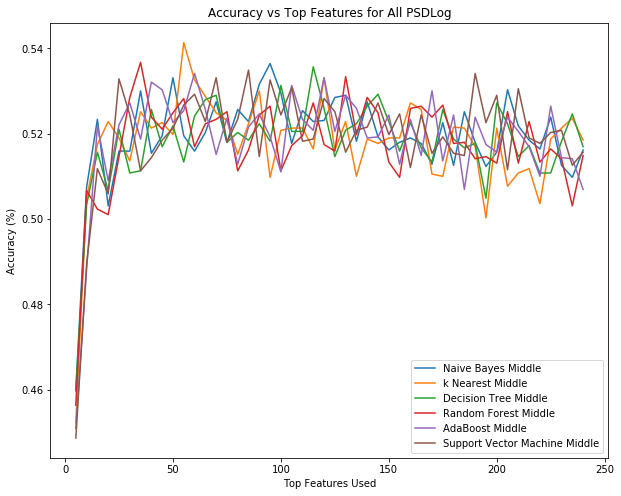

In [106]:
plot_classifiers_vs_n_features(2, 'All')

Important to note that X Accel and Y accel of the wheels are virtually the same since their direction changes as the wheel rotates

## Part 11 - Classification on Single Axes

### Part (a) - Separate Combined Data

In [107]:
'''Get placement dictionary of combined data truncated to only include columns matching given tag'''
def get_matching_columns(combined_data, column_match):
    # New placement dictionary with only matching columns
    combined_matching_data = {}
    
    for placement, placement_data in combined_data.items():
        # Retrieve column names that match the given match parameter
        matching_columns = [column for column in placement_data.columns if column_match in column]
        matching_columns.append('Label')
        combined_matching_data.update({placement: placement_data[matching_columns]})
        
    return combined_matching_data

In [108]:
'''Separate combined dataframe into dictionary of axes columns'''
def separate_combined(combined_data):
    separated_data = {}
    
    for axes_column in data_columns:
        separated_data.update({axes_column: get_matching_columns(combined_data, axes_column)})
        
    return separated_data

In [109]:
feat_separated = separate_combined(feat_combined)
fft_separated = separate_combined(fft_combined)
psd_log_separated = separate_combined(psd_log_combined)

feat_separated['Z Accel']['Middle'].head()

,Mean Z Accel Middle,Std Dev Z Accel Middle,L2 Norm Z Accel Middle,Autocorrelation Z Accel Middle,Max Z Accel Middle,Min Z Accel Middle,Root Mean Squared Z Accel Middle,Zero Crossing Rate Z Accel Middle,Skew Z Accel Middle,Excess Kurtosis Z Accel Middle,Mean Square Frequency Z Accel Middle,Root Mean Square Frequency Z Accel Middle,Frequency Center Z Accel Middle,Variance Frequency Z Accel Middle,Root Variance Frequency Z Accel Middle,Label
0,0.122339,-1.008275,-1.009104,-0.899187,-0.681546,1.023153,-1.009104,1.566721,1.780103,0.401485,-0.456228,-0.401738,1.075185,-1.192810,-0.401738,6
1,-0.182195,-1.578249,-1.578728,-1.199407,-1.867886,1.367937,-1.578728,-0.639562,-1.483517,-0.442405,-0.926447,-1.397661,-1.693770,0.937022,-1.397661,6
2,-0.776866,-0.696951,-0.696603,-0.695432,-0.402445,-0.086405,-0.696603,-0.394419,1.154003,1.526448,-0.529610,-0.519713,0.086255,-0.333001,-0.519713,6
3,1.484097,1.939577,1.939385,2.124270,1.426864,-1.482568,1.939385,-0.639562,-0.640592,-0.656278,1.882451,1.869241,0.749348,0.366038,1.869241,6
4,-0.402704,2.691306,2.690768,3.288577,2.007963,-2.053580,2.690768,0.831293,-0.214282,-0.508332,5.626296,3.975964,0.494108,2.610364,3.975964,6


### Part (b) - Compute Accuracy Table for Single Axes

In [110]:
def create_axes_accuracy_table(n_splits):
    # Dataframe table of accuracies for each classifier for each placement
    vector_indices = [vector + ' ' + placement + ' ' + axis for axis in data_columns for placement in placements for vector in vector_names]
    axes_accuracy_table = pd.DataFrame({'Vector': vector_indices})

    # Calculate accuracy for each axes of each placement for each feature vector and classifier
    for classifier_name, classifier in classifiers.items():
        model = classifier

        # Row dictionary for given model
        rows = {}

        for axis in data_columns:
            # Get k fold predict and actual labels for each vector for current axis
            feat  = train_test_k_fold(feat_separated[axis], n_splits, model)
            fft = train_test_k_fold(fft_separated[axis], n_splits, model)
            psd_log = train_test_k_fold(psd_log_separated[axis], n_splits, model)
            vectors = (feat, fft, psd_log)

            # Add current axis and classifier to row dictionary
            for i, vector_name in enumerate(vector_names):
                for placement in placements:
                    index_name = vector_name + ' ' + placement + ' ' + axis

                    # Extract predicted and actual labels
                    predict, actual = vectors[i][placement]

                    # Take mean accuracy of k fold testing
                    accuracies = []
                    for j in range(len(predict)):
                        accuracies.append(accuracy_score(actual[j], predict[j]))
                    rows.update({index_name: np.mean(accuracies)})

            # Update accuracy table with classifier column by mapping row names to indices
            axes_accuracy_table[classifier_name] = axes_accuracy_table['Vector'].map(rows)
    
    return axes_accuracy_table

In [111]:
axes_accuracy_table = create_axes_accuracy_table(5)

In [112]:
axes_accuracy_table

,Vector,Naive Bayes,k Nearest,Decision Tree,Random Forest,AdaBoost,Support Vector Machine
0,ExtractedFeatures Middle X Accel,0.109859,0.244608,0.271815,0.340092,0.239223,0.296711
1,FFT Middle X Accel,0.413498,0.377312,0.366271,0.507962,0.380393,0.515144
2,PSDLog Middle X Accel,0.424280,0.320846,0.365246,0.508733,0.384500,0.501281
3,ExtractedFeatures Middle Y Accel,0.128843,0.340345,0.389114,0.500774,0.301848,0.399894
4,FFT Middle Y Accel,0.507450,0.490753,0.428638,0.601383,0.371913,0.601134
5,PSDLog Middle Y Accel,0.512829,0.469967,0.413241,0.589837,0.388606,0.594454
6,ExtractedFeatures Middle Z Accel,0.114987,0.256411,0.279777,0.399636,0.252305,0.319043
7,FFT Middle Z Accel,0.517455,0.522072,0.457650,0.613958,0.403233,0.594713
8,PSDLog Middle Z Accel,0.517968,0.480749,0.438403,0.591898,0.391178,0.587786
9,ExtractedFeatures Middle X Gyro,0.112937,0.327518,0.290043,0.430180,0.261294,0.377825


### Glossary

`Dataset` - Batch of data recorded on one terrain type

`Data Window` - Split up portion of a `Dataset`

`Direction / Axes` - Linear acceleration or gyroscope in $x,y$ or $z$

`Feature Vector` - Any feature of the data that can be used to classify terrain, e.g. Z Accel Mean, Y Accel FFT, etc

`Extracted Feature Vector` - Features that aren't from transforms, e.g. Z Accel Min, Y Accel Autocorrelation, etc

`Placement` - One of three IMU placements on the wheelchair, i.e. Middle, Left, or Right